# Evaluating the neuron quality
### Take the data from the neuronal segmentation pipeline and evaluate which neurons are good, save results

In [1]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
from matplotlib.path import Path
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix
from scipy.stats import sem
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import linear_model as lm

from scipy.ndimage import binary_erosion
from scipy.ndimage import grey_erosion

import cv2

from ipyfilechooser import FileChooser

Load the data

In [2]:
# Set the starting folder
start_path = 'D:\\' 
%cd $start_path

# Create and display a FileChooser widget
fc = FileChooser(start_path)
fc.use_dir_icons = True
display(fc)

D:\


FileChooser(path='D:\', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Change', …

In [3]:
# Load the data
#path = 'D:/CaIm/os80/b2/'
path = fc.selected_path + '\\'

traces_path = path + 'traces.json'
component_locations_path = path + 'component_locations.json'
filter_img_path = path + 'filter_img.json'
accepted_path = path + 'accepted.json'
with open(traces_path, 'r') as json_file:
    traces_list = json.load(json_file)
with open(component_locations_path, 'r') as json_file:
    component_locations_list = json.load(json_file)
with open(filter_img_path, 'r') as json_file:
    filter_img = json.load(json_file)
with open(accepted_path, 'r') as json_file:
    accepted_list = json.load(json_file)

# Convert to convinient formats
component_locations = np.array(component_locations_list)
component_locations_sparse = csc_matrix(component_locations)
traces = np.array(traces_list)
filter_img = np.array(filter_img)

# Display the number of components total and the rejected ones
print(f"Total number of components: {traces.shape[0]}, accepted: {len(accepted_list)}")
      
# Select only accepted:
component_locations = component_locations[:,accepted_list]
traces = traces[accepted_list,:]

Total number of components: 445, accepted: 352


In [4]:

''' accepted_list
unaccepted = [i for i in np.arange(traces.shape[0]) if i not in accepted_list]
unaccepted
component_locations = component_locations[:,unaccepted]
traces = traces[unaccepted,:]
'''

' accepted_list\nunaccepted = [i for i in np.arange(traces.shape[0]) if i not in accepted_list]\nunaccepted\ncomponent_locations = component_locations[:,unaccepted]\ntraces = traces[unaccepted,:]\n'

## Select a polygon where neurons could be

In [5]:
%matplotlib widget
'''
fig, ax = plt.subplots()
ax.imshow(filter_img, cmap='gray')
polygon_points = []
polygon_complete = False

def on_click(event):
    if event.inaxes is not None:
        polygon_points.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')  # Mark the vertices

def on_key_p(event):
    global polygon_points
    if event.key == 'p':  # on pressing 'p'
        poly = Polygon(polygon_points, closed=True, edgecolor='r', fill=False)
        ax.add_patch(poly)
        fig.canvas.mpl_disconnect(cid) 
        plt.draw()
        print("Polygon complete")


cid = fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key_p)
plt.show()
'''

'\nfig, ax = plt.subplots()\nax.imshow(filter_img, cmap=\'gray\')\npolygon_points = []\npolygon_complete = False\n\ndef on_click(event):\n    if event.inaxes is not None:\n        polygon_points.append((event.xdata, event.ydata))\n        ax.plot(event.xdata, event.ydata, \'ro\')  # Mark the vertices\n\ndef on_key_p(event):\n    global polygon_points\n    if event.key == \'p\':  # on pressing \'p\'\n        poly = Polygon(polygon_points, closed=True, edgecolor=\'r\', fill=False)\n        ax.add_patch(poly)\n        fig.canvas.mpl_disconnect(cid) \n        plt.draw()\n        print("Polygon complete")\n\n\ncid = fig.canvas.mpl_connect(\'button_press_event\', on_click)\nfig.canvas.mpl_connect(\'key_press_event\', on_key_p)\nplt.show()\n'

## Discard components outside of the polygon

In [6]:
'''
# Original dimentions
d1 = filter_img.shape[0]
d2 = filter_img.shape[1]

def calculate_centroid(component_locations, component_num, d1, d2):
    """Calculate the centroid of a component."""
    component = component_locations[:, component_num].reshape(d2, d1, order='F')
    ys, xs = np.nonzero(component)
    if len(xs) == 0 or len(ys) == 0:
        return None  # or some default value like (0, 0)
    return np.mean(xs), np.mean(ys)

centroids = [calculate_centroid(component_locations, i, d1, d2) for i in np.arange(component_locations.shape[1])]

# Filter out None values if there are any
centroids = [centroid for centroid in centroids if centroid is not None]


def is_inside_polygon(points, polygon):
    path = Path(polygon)
    return np.array([path.contains_point(point) for point in points])

is_inside = is_inside_polygon(centroids, polygon_points)

# Filter arrays
print(f"Total number of components before: {traces.shape[0]}")
#component_locations = component_locations[:, is_inside]
#traces = traces[is_inside, :]
print(f"Now: {sum(is_inside)}")
'''

'\n# Original dimentions\nd1 = filter_img.shape[0]\nd2 = filter_img.shape[1]\n\ndef calculate_centroid(component_locations, component_num, d1, d2):\n    """Calculate the centroid of a component."""\n    component = component_locations[:, component_num].reshape(d2, d1, order=\'F\')\n    ys, xs = np.nonzero(component)\n    if len(xs) == 0 or len(ys) == 0:\n        return None  # or some default value like (0, 0)\n    return np.mean(xs), np.mean(ys)\n\ncentroids = [calculate_centroid(component_locations, i, d1, d2) for i in np.arange(component_locations.shape[1])]\n\n# Filter out None values if there are any\ncentroids = [centroid for centroid in centroids if centroid is not None]\n\n\ndef is_inside_polygon(points, polygon):\n    path = Path(polygon)\n    return np.array([path.contains_point(point) for point in points])\n\nis_inside = is_inside_polygon(centroids, polygon_points)\n\n# Filter arrays\nprint(f"Total number of components before: {traces.shape[0]}")\n#component_locations = comp

## Make components sharper

In [7]:
component_locs_sharp =[]
for n in np.arange(component_locations.shape[1]):
    comp = component_locations[:,n]
    comp_no0 = comp[comp>0]
    
    if len(comp_no0) >=2:
        mean_comp = np.mean(comp_no0)
        sd_comp = statistics.stdev(comp_no0)
        cutoff = mean_comp*1.1
        sharper = np.where(comp < cutoff, 0, comp)
        component_locs_sharp.append(sharper)
    else:
      #  if is_inside[n]:
      #      print(f'Wow component inside so smol: {n}')
        component_locs_sharp.append(comp)


## Make image of all components outlines on top of the filtered image and just look at it

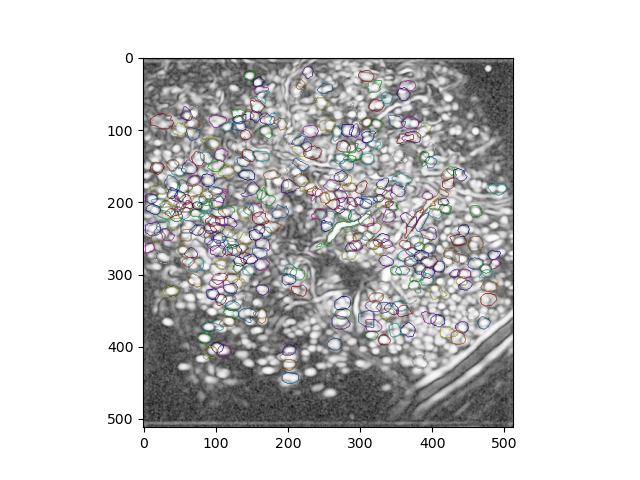

In [8]:
# Original dimentions
d1 = filter_img.shape[0]
d2 = filter_img.shape[1]

fig, ax = plt.subplots()
ax.imshow(filter_img, cmap='gray')

colors = [ [ 1,  0,  0, 1],
           [ 0,  1,  0, 1],
           [ 0,  0,  1, 1],
           [ 0,  1,  1, 1],
           [ 1,  0,  1, 1],
           [ 1,  1,  0, 1],
           [ 1,  1,  1, 1],
           [.5,  0,  1, 1],
           [ 1, .5,  0, 1],
           [ 0, .5,  1, 1],
         ]

def plot_boundaries(ax, component, color):

    # Convert to boolean 
    component_bool = component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(component_bool)
    boundaries = component_bool & ~eroded
    # Create a color mask: yellow for True, transparent for False
    color_mask = np.zeros((boundaries.shape[0], boundaries.shape[1], 4))  # Initialize a RGBA color mask
    color_mask[boundaries] = color  # Yellow (R=1, G=1, B=0, A=1) for True values
    # Overlay boundaries
    ax.imshow(color_mask, cmap='gray', alpha=1)
    

for n in np.arange(len(component_locs_sharp)):
  #  if is_inside[n]:
    color = colors[:][n%len(colors)]
    component = np.array(component_locs_sharp[n])
    component = component.reshape(d2, d1, order='F')
    plot_boundaries(ax, component, color)

plt.show()

In [9]:
plt.savefig(path + 'sharp_outlines.png')  # Save as PNG file

In [10]:
#component_locations = component_locations[:, is_inside]
component_locs_sharp = np.array(component_locs_sharp)
#component_locs_sharp = component_locs_sharp[:][is_inside]
#traces = traces[is_inside, :]

In [11]:
component_locations.shape[1]

352

In [12]:
# Define the component number
#comp_n = component_num  # Adjust this as needed
#comp_n = 1
# Reshape the component's heatmap to 2D
#comp_heatmap = component_locations[:, comp_n].reshape(filter_img.shape, order='F')

# Calculate the center of the component using the centroid formula
#y_indices, x_indices = np.indices(comp_heatmap.shape)
# Find other components' centers in the subsection
all_centers = []
for i in range(component_locations.shape[1]):
    heatmap = component_locations[:, i].reshape(filter_img.shape, order='F')
    y_indices, x_indices = np.indices(heatmap.shape)
    y = int(np.sum(heatmap * y_indices) / np.sum(heatmap))
    x = int(np.sum(heatmap * x_indices) / np.sum(heatmap))
    all_centers.append((i, x, y))


In [13]:
component_locations.shape[1]

352

## plot a neuron location on the overlay of the max image and a trace of this neuron

132 182 44 94


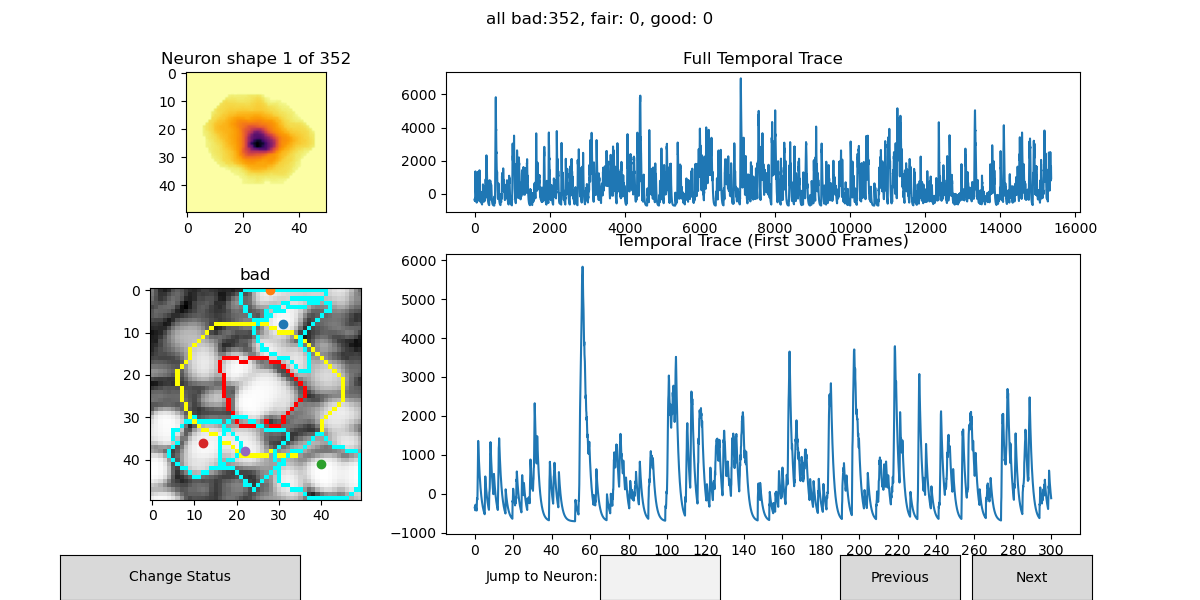

In [14]:
%matplotlib widget
#component_locations = component_locations[:, is_inside]
#traces = traces[is_inside, :]
# Initial component number
component_num = 0
fair_list = [0]*component_locations.shape[1]
good_list = [0]*component_locations.shape[1]

# Plot a certain neuron
def update_plot(component_num):

    spatial_comp = component_locations[:, component_num].reshape(d2, d1, order='F')
    spatial_comp_sharp = component_locs_sharp[:][component_num].reshape(d2, d1, order='F')
    temporal_comp = traces[component_num, :]
   # centroid_x, centroid_y = calculate_centroid(component_locations, component_num, d1, d2)

    # Define crop boundaries
    centroid_y, centroid_x = np.unravel_index(np.argmax(spatial_comp, axis=None),spatial_comp.shape)
    crop_size = 25
    x_min, x_max = round(max(0, centroid_x - crop_size)), round(min(d2, centroid_x + crop_size))
    y_min, y_max = round(max(0, centroid_y - crop_size)), round(min(d1, centroid_y + crop_size))
    print(x_min, x_max, y_min, y_max)
    crop_bounds = (y_min, y_max, x_min, x_max)
    # Crop the image and spatial_comp
    crop_image = filter_img[y_min:y_max, x_min:x_max]
    crop_spatial_comp = spatial_comp[y_min:y_max, x_min:x_max]
    crop_spatial_comp_sharp = spatial_comp_sharp[y_min:y_max, x_min:x_max]
    
    axs[0].clear()
    axs[0].imshow(crop_spatial_comp, cmap='inferno_r')
    axs[0].set_title(f'Neuron shape {component_num + 1} of {len(fair_list)}')
    
    axs[1].clear()
    # calculate how many of each neuron classification is there now
    all_good = sum(good_list)
    all_fair = sum(fair_list)
    all_bad = len(good_list) - all_good - all_fair
    fig.suptitle(f'all bad:{all_bad}, fair: {all_fair}, good: {all_good}')
    if good_list[component_num] == 1:
        axs[1].set_title(f'good;')
    elif fair_list[component_num] == 1:
        axs[1].set_title(f'fair')
    else:
        axs[1].set_title(f'bad')
    axs[1].imshow(crop_image, cmap='grey')
    # axs[1].imshow(crop_spatial_comp, cmap='inferno_r', alpha=0.3)
    plot_boundaries(axs[1], crop_spatial_comp, [1,1,0,1], crop_bounds)
    plot_boundaries(axs[1], crop_spatial_comp_sharp, [1,0,0,1], crop_bounds)
    for idx, x, y in all_centers:
        if idx != component_num:
            if y_min <= y < y_max and x_min <= x < x_max:
                axs[1].scatter(x - x_min, y  - y_min, label=f'# {idx+1}')
                # plot sharp outlines
                spatial_comp_sharp = component_locs_sharp[:][idx].reshape(d2, d1, order='F')
                crop_spatial_comp_sharp = spatial_comp_sharp[y_min:y_max, x_min:x_max]
                plot_boundaries(axs[1], crop_spatial_comp_sharp, [0,1,1,1], crop_bounds)
   
 #   axs[1].set_title(f'Neuron location {component_num + 1}')
    
    # Plot temporal components
    temporal_comp = traces[component_num, :]
    axs[2].clear()
    axs[2].plot(temporal_comp)
    axs[2].set_title(f'Full Temporal Trace')


    axs[3].clear()

    axs[3].plot(temporal_comp[:3000])
    axs[3].set_title('Temporal Trace (First 3000 Frames)')
    axs[3].set_xticks(np.arange(0,3001,200), np.arange(0,301,20))
    
    plt.draw()

def job_done():
    # Create plot with GridSpec
    for a in [0,1,2,3]:
        axs[a].clear()
        fig.delaxes(axs[a])
    
   # fig_end = plt.figure(figsize=(12,3))
    plt.ylim(-1, 1)
    plt.xlim(-0.1, 0.5)
    plt.text(0.15,10, 'all done 😄', fontsize=100)
    plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    plt.show()

def next_neuron(event):
    global component_num
     # Check if the component is inside the previously selected polygon, if not - skip to the next one
    if component_num < component_locations.shape[1]-1:
        component_num = (component_num + 1) # % component_locations.shape[1]
        update_plot(component_num)
    else:
        job_done()
        
def prev_neuron(event):
    global component_num
    # Check if the component is inside the previously selected polygon, if not - skip to the previous one
    component_num = (component_num - 1) % component_locations.shape[1]
    update_plot(component_num)

def jump_to_neuron(text):
    global component_num
    component_num = int(text) - 1
    update_plot(component_num)

def change_status(event):
    good_list[component_num] = 1 # if good_list[component_num] == 0 else 0
   # print(f"Status of Neuron {component_num + 1}: {good_list[component_num]}")

def on_key_g(event):
    global component_num, good_list, fair_list
    if event.key == 'g':  
        good_list[component_num] = 1 # if good_list[component_num] == 0 else 0
        fair_list[component_num] = 0
        all_good = sum(good_list)
        all_fair = sum(fair_list)
        all_bad = len(good_list) - all_good - all_fair
      #  print(f"Status of Neuron {component_num + 1}: {good_list[component_num]}")
        axs[1].set_title(f'good')
        fig.suptitle(f'all bad:{all_bad}, fair: {all_fair}, good: {all_good}')
     #   update_plot(component_num)  

def on_key_f(event): # fair
    global component_num, fair_list, good_list
    if event.key == 'f':  
        fair_list[component_num] = 1 # if good_list[component_num] == 0 else 0
        good_list[component_num] = 0
        all_good = sum(good_list)
        all_fair = sum(fair_list)
        all_bad = len(good_list) - all_good - all_fair
        #print(f"Status of Neuron {component_num + 1}: {good_list[component_num]}")
        axs[1].set_title(f'fair')
        fig.suptitle(f'all bad:{all_bad}, fair: {all_fair}, good: {all_good}')
      #  update_plot(component_num)  

def on_key_b(event): # bad
    global component_num, good_list, fair_list
    if event.key == 'b':  
        good_list[component_num] = 0 # if good_list[component_num] == 0 else 0
        fair_list[component_num] = 0
        all_good = sum(good_list)
        all_fair = sum(fair_list)
        all_bad = len(good_list) - all_good - all_fair
        axs[1].set_title(f'bad')
        fig.suptitle(f'all bad:{all_bad}, fair: {all_fair}, good: {all_good}')
       # print(f"Status of Neuron {component_num + 1}: {good_list[component_num]}")
      #  update_plot(component_num) 

def on_key_d(event): # bad
    if event.key == 'd':  
        next_neuron(event)
def on_key_e(event): # bad
    if event.key == 'e':  
        prev_neuron(event)

def plot_boundaries(ax, component, color,  crop_bounds=None):
    if crop_bounds==None:
        crop_comp = component
    else:
        y_min, y_max, x_min, x_max = crop_bounds
        crop_comp = component[y_min:y_max, x_min:x_max]
    # Convert to boolean 
    component_bool = component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(component_bool)
    boundaries = component_bool & ~eroded
    # Create a color mask: yellow for True, transparent for False
    color_mask = np.zeros((boundaries.shape[0], boundaries.shape[1], 4))  # Initialize a RGBA color mask
    color_mask[boundaries] = color  # Yellow (R=1, G=1, B=0, A=1) for True values
    # Overlay boundaries
    ax.imshow(color_mask, cmap='gray', alpha=1)



# Create plot with GridSpec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 3])  # Adjust ratios as needed

ax0 = fig.add_subplot(gs[0, 0])  # 0st subplot for the component map
ax1 = fig.add_subplot(gs[1, 0])  # First subplot for the neuron image
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot for the entire trace
ax3 = fig.add_subplot(gs[1, 1])  # Third subplot for the zoomed trace

axs = [ax0, ax1, ax2, ax3]

update_plot(component_num)

# Adjust button positions
axprev = plt.axes([0.7, 0.0, 0.1, 0.075])
axnext = plt.axes([0.81, 0.0, 0.1, 0.075])
axtextbox = plt.axes([0.5, 0.0, 0.1, 0.075])
axstatus = plt.axes([0.05, 0.0, 0.2, 0.075])

# 
btn_next = Button(axnext, 'Next')
btn_next.on_clicked(next_neuron)

btn_prev = Button(axprev, 'Previous')
btn_prev.on_clicked(prev_neuron)

text_box = TextBox(axtextbox, 'Jump to Neuron:')
text_box.on_submit(jump_to_neuron)

btn_status = Button(axstatus, 'Change Status')
btn_status.on_clicked(change_status)
fig.canvas.mpl_connect('key_press_event', on_key_g)
fig.canvas.mpl_connect('key_press_event', on_key_f)
fig.canvas.mpl_connect('key_press_event', on_key_b)
fig.canvas.mpl_connect('key_press_event', on_key_d)
fig.canvas.mpl_connect('key_press_event', on_key_e)
plt.show()

In [ ]:
path

In [ ]:
'''
# Define the component number
comp_n = component_num  # Adjust this as needed
comp_n = comp_n
# Reshape the component's heatmap to 2D
comp_heatmap = component_locations[:, comp_n].reshape(filter_img.shape, order='F')

# Calculate the center of the component using the centroid formula
y_indices, x_indices = np.indices(comp_heatmap.shape)
center_y = int(np.sum(comp_heatmap * y_indices) / np.sum(comp_heatmap))
center_x = int(np.sum(comp_heatmap * x_indices) / np.sum(comp_heatmap))

# Define the area to extract around the center
half_size = 25  # 50 pixels in each direction
min_row, max_row = int(max(0, center_y - half_size)), int(min(filter_img.shape[0], center_y + half_size))
min_col, max_col = int(max(0, center_x - half_size)), int(min(filter_img.shape[1], center_x + half_size))
crop_bounds = (min_row, max_row, min_col, max_col)

# Extract the subsection
subsection = filter_img[min_row:max_row, min_col:max_col]

# Find other components' centers in the subsection
all_centers = []
for i in range(component_locations.shape[1]):
    heatmap = component_locations[:, i].reshape(filter_img.shape, order='F')
    y = int(np.sum(heatmap * y_indices) / np.sum(heatmap))
    x = int(np.sum(heatmap * x_indices) / np.sum(heatmap))
    if min_row <= y < max_row and min_col <= x < max_col:
        all_centers.append((i, x, y))


# Plot the results
fig, ax = plt.subplots()
ax.imshow(subsection, cmap='gray')
ax.scatter(center_x - min_col, center_y - min_row, c='red', label=f'The {comp_n+1}')  # center of the main component
# plot sharp outlines of the main comp
spatial_comp_sharp = component_locs_sharp[:][comp_n].reshape(d2, d1, order='F')
crop_spatial_comp_sharp = spatial_comp_sharp[min_row:max_row, min_col:max_col]
plot_boundaries(ax, crop_spatial_comp_sharp, [0,0,1,1], crop_bounds)
for idx, x, y in all_centers:

    if idx != comp_n:
        ax.scatter(x - min_col, y - min_row, label=f'# {idx+1}')
        # plot sharp outlines
        spatial_comp_sharp = component_locs_sharp[:][idx].reshape(d2, d1, order='F')
        crop_spatial_comp_sharp = spatial_comp_sharp[min_row:max_row, min_col:max_col]
        plot_boundaries(ax, crop_spatial_comp_sharp, [1,1,0,1], crop_bounds)

ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()
'''

In [ ]:
# Convert good_list to a DataFrame
status_df = pd.DataFrame(good_list, columns=['Status'])
fair_df = pd.DataFrame(fair_list, columns=['Fair'])
is_inside = [[True]]*len(fair_list)
inside_df = pd.DataFrame(is_inside, columns=['Inside'])
status_df.to_csv(path+'good_neurons.csv', index=False)
fair_df.to_csv(path+'fair_neurons.csv', index=False)
inside_df.to_csv(path+'inside_neurons.csv', index=False)


In [ ]:
sum(fair_list)


In [ ]:
sum(good_list)

In [ ]:
path

In [ ]:
good_list